## Эксперимент - обучение проводится 4 эпохи вместо 10

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

import os

import matplotlib.pyplot as plt


2024-12-21 21:37:23.386269: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-21 21:37:23.395324: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734817043.408894  385301 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734817043.412261  385301 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-21 21:37:23.423786: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

train_dir = 'dataset_train'
test_dir = 'dataset_test'

image_size = (150, 150)
batch_size = 32
epochs = 4

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)


Found 1056 images belonging to 2 classes.
Found 4231 images belonging to 2 classes.


### Настраиваем и компилим модель

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


/home/v131v/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-12-21 21:37:24.919264: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


### Обучаем модель на тренировочном датасете

In [4]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)


/home/v131v/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/4
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.5293 - loss: 1.3721

/home/v131v/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 664ms/step - accuracy: 0.5310 - loss: 1.3577 - val_accuracy: 0.8326 - val_loss: 0.4058
Epoch 2/4
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 661ms/step - accuracy: 0.8195 - loss: 0.4270 - val_accuracy: 0.8892 - val_loss: 0.2584
Epoch 3/4
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 680ms/step - accuracy: 0.8413 - loss: 0.3639 - val_accuracy: 0.8601 - val_loss: 0.3461
Epoch 4/4
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 685ms/step - accuracy: 0.8787 - loss: 0.3437 - val_accuracy: 0.9093 - val_loss: 0.2462


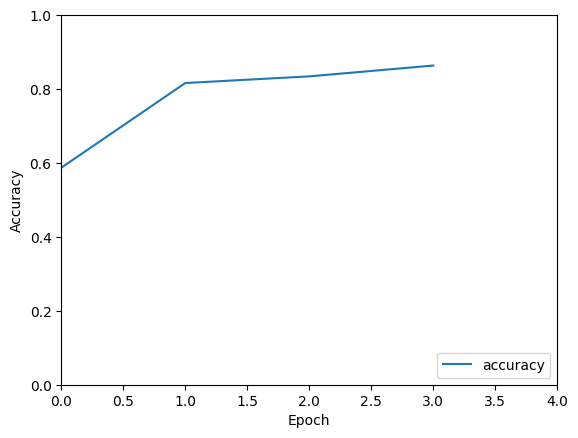

In [5]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.xlim([0, epochs])
plt.legend(loc='lower right')
plt.show()


### Оценка точности

In [6]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Точность на тестовых данных: {test_acc}")


133/133 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - accuracy: 0.9177 - loss: 0.2315
Точность на тестовых данных: 0.9094776511192322


### Результат - точность почти как с 10 эпохами

### Сохраняем модельку в keras формате

In [7]:
# Сохранение модели
model.save('butterfly_classifier.keras')
